In [1]:
from LogDict import FlashLogDict
import numpy
import matplotlib.pyplot as pyplot
import matplotlib.ticker as mticker
from types import SimpleNamespace

In [2]:
def LogNamespace(logfile):
    logdict = FlashLogDict(logfile, stats=True)
    log = SimpleNamespace(evolution = 0., communication = 0., nucleation = 0., multiphase = 0.,
                          incomp = 0., heat = 0., io = 0., poisson = 0., simtime = 0., walltime = 0., iters=0)

    metric = "avg/proc"
    
    for key in logdict.keys():
        if key == "evolution":
            log.evolution = log.evolution + logdict[key][metric]
        if key == "guardcell internal":
            log.communication = log.communication + logdict[key][metric]
        if key == "Grid_solvePoisson":
            log.poisson = log.poisson + logdict[key][metric]
        if "sim_heater" in key:
            log.nucleation = log.nucleation + logdict[key][metric]
        if "Multiphase" in key:
            log.multiphase = log.multiphase + logdict[key][metric]
        if ("IncompNS" in key) or (key == "sim_outletSetForcing"):
            log.incomp = log.incomp + logdict[key][metric]
        if "HeatAD" in key:
            log.heat = log.heat + logdict[key][metric]
        if key == "IO_output":
            log.io = log.io + logdict[key][metric]
            
    return log

In [3]:
SummitNodes25 = LogNamespace("../../simulation/FlowBoiling/Example3D/jobnode.archive/2023-10-03/INS_Flow_Boiling.log")                              
SummitNodes12 = LogNamespace("../../simulation/FlowBoiling/WeakScaling/nodes12/jobnode.archive/2023-10-04/INS_Flow_Boiling.log")
SummitNodes05 = LogNamespace("../../simulation/FlowBoiling/WeakScaling/nodes05/jobnode.archive/2023-10-03/INS_Flow_Boiling.log")
SummitNodes50 = LogNamespace("./jobnode.archive/summit/INS_Flow_Boiling_summit_nodes50.log")
HPC3 = LogNamespace("./jobnode.archive/hpc3/INS_Pool_Boiling.log")

In [4]:
SummitNodes25.simtime = 0.5*10
SummitNodes25.walltime = round(6553.903/60/60,1)
SummitNodes25.iters=5849

SummitNodes12.simtime = 0.5*10
SummitNodes12.walltime = round(5882.297/60/60,1)
SummitNodes12.iters=5569

SummitNodes05.simtime = 0.5*10
SummitNodes05.walltime = round(4142.082/60/60,1)
SummitNodes05.iters=4931

SummitNodes50.simtime = 0.43*10
SummitNodes50.walltime = round(6000/60/60,1)
SummitNodes50.iters=3234

HPC3.simtimes = 1*10
HPC3.walltime = round(19999.007/60/60,1)
HPC3.iters=9634

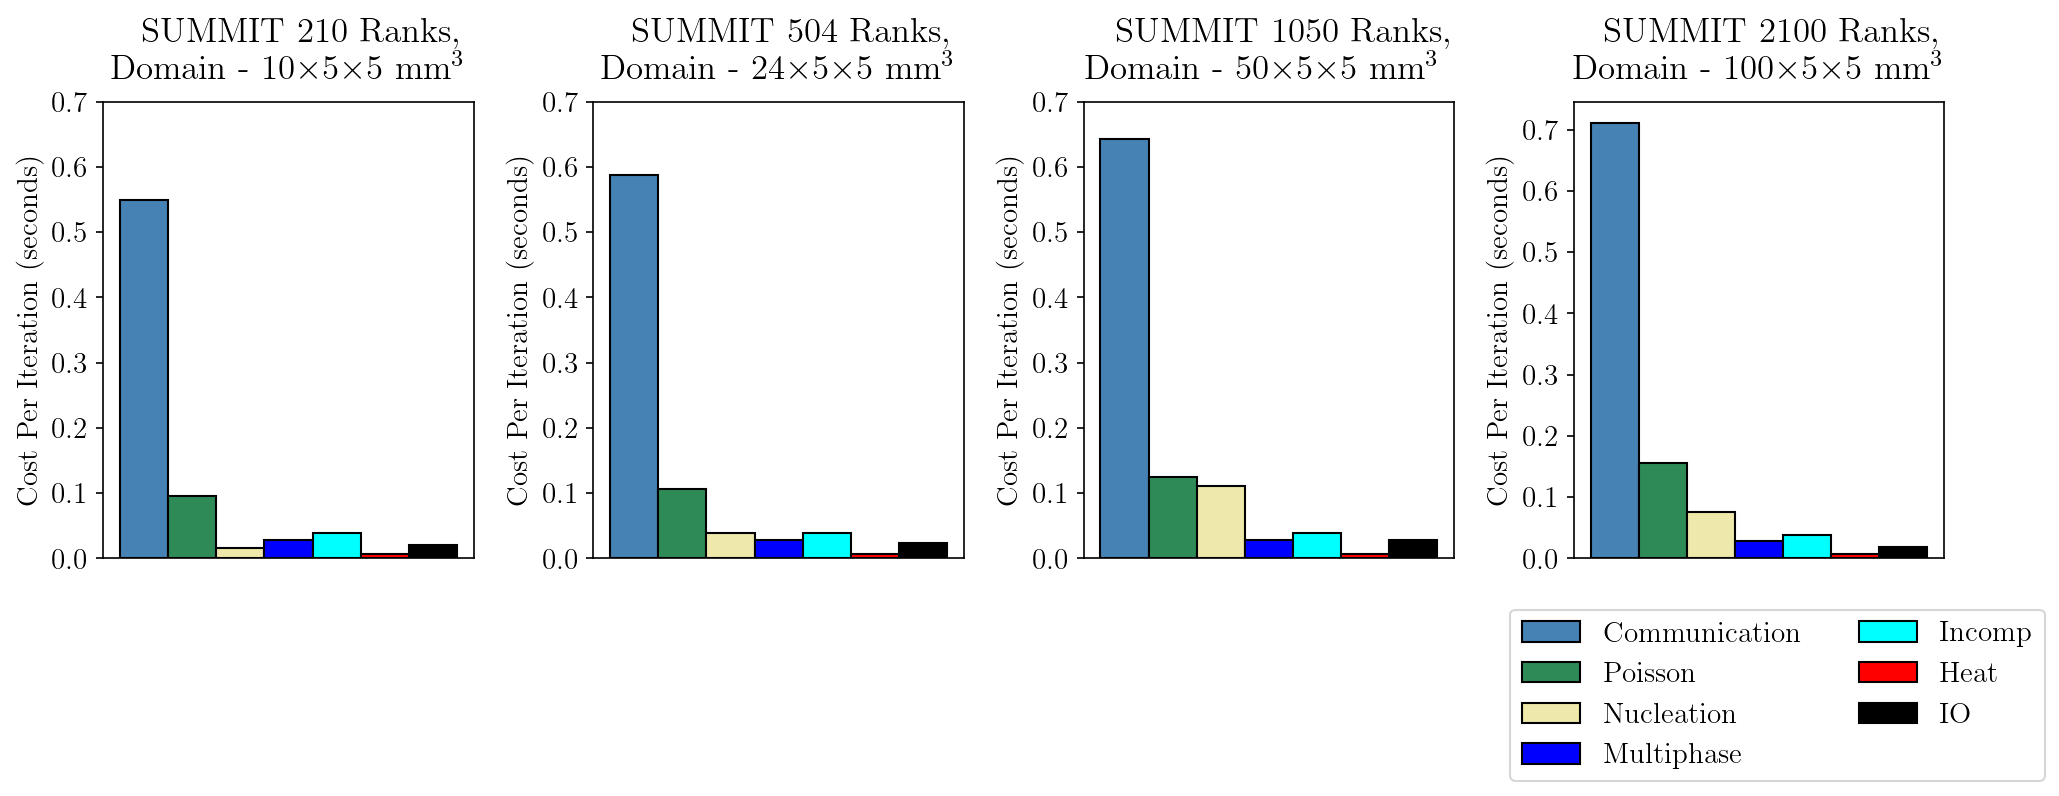

In [5]:
# Plot figure
pyplot.rc("font", family="serif", size=14, weight="bold")
pyplot.rc("axes", labelweight="bold", titleweight="bold")
pyplot.rc("text", usetex=True)
figure = pyplot.figure(figsize=(14,6), dpi=150)

AxList = figure.subplots(1,4)
Titles = [r"SUMMIT 210 Ranks,$\\$Domain - 10$\times$5$\times$5 mm$^3$", 
          r"SUMMIT 504 Ranks,$\\$Domain - 24$\times$5$\times$5 mm$^3$",
          r"SUMMIT 1050 Ranks,$\\$Domain - 50$\times$5$\times$5 mm$^3$",
          r"SUMMIT 2100 Ranks,$\\$Domain - 100$\times$5$\times$5 mm$^3$"]

for ax, log, title  in zip(AxList, [SummitNodes05, SummitNodes12, SummitNodes25, SummitNodes50], Titles):

    labels = ["Communication", "Poisson", "Nucleation", "Multiphase", "Incomp", "Heat", "IO"]

    bar = []
    color = iter(["steelblue", "seagreen", "palegoldenrod", "blue", "cyan", "red", "black"])
    x = 0.0
    for lb in labels:
        bar.append(ax.bar(x, (getattr(log,lb.lower())/log.iters), 
                          color=next(color),
                          edgecolor="black", align='center', width=0.05))
        
        x = x+0.05
               
    ax.set_title(title,pad=30)
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel(r"Cost Per Iteration (seconds)")
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

ax.legend(bar,labels,ncol=2,loc="center",bbox_to_anchor=(0.55, -0.3))
#pyplot.title("Weak Scaling for Flow Boiling Simulation")
pyplot.tight_layout()
#pyplot.savefig("/Users/Akash/Desktop/summit01.png")

In [6]:
def CostPerIteration(key):
    if key == "physics":
        cost = numpy.array([getattr(SummitNodes05,"incomp")/SummitNodes05.iters,
                 getattr(SummitNodes12,"incomp")/SummitNodes12.iters,
                 getattr(SummitNodes25,"incomp")/SummitNodes25.iters,
                 getattr(SummitNodes50,"incomp")/SummitNodes50.iters])
        cost = cost + numpy.array([getattr(SummitNodes05,"multiphase")/SummitNodes05.iters,
                 getattr(SummitNodes12,"multiphase")/SummitNodes12.iters,
                 getattr(SummitNodes25,"multiphase")/SummitNodes25.iters,
                 getattr(SummitNodes50,"multiphase")/SummitNodes50.iters])
        cost = cost + numpy.array([getattr(SummitNodes05,"heat")/SummitNodes05.iters,
                 getattr(SummitNodes12,"heat")/SummitNodes12.iters,
                 getattr(SummitNodes25,"heat")/SummitNodes25.iters,
                 getattr(SummitNodes50,"heat")/SummitNodes50.iters])
        
    else:
        cost = numpy.array([getattr(SummitNodes05,key)/SummitNodes05.iters,
                 getattr(SummitNodes12,key)/SummitNodes12.iters,
                 getattr(SummitNodes25,key)/SummitNodes25.iters,
                 getattr(SummitNodes50,key)/SummitNodes50.iters])
    cost = cost/numpy.min(cost)
    return cost.tolist()

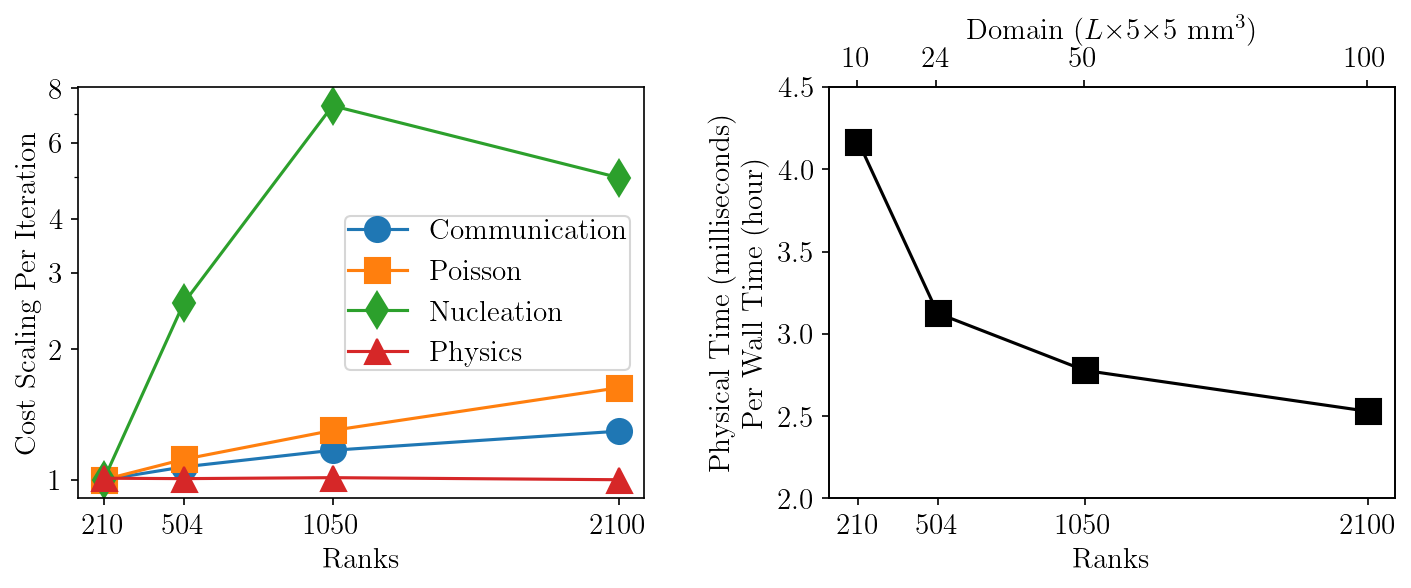

In [7]:
# Plot figure
pyplot.rc("font", family="serif", size=14, weight="bold")
pyplot.rc("axes", labelweight="bold", titleweight="bold")
pyplot.rc("text", usetex=True)
figure = pyplot.figure(figsize=(10, 4.5), dpi=150)

ProcList = [210, 504, 1050, 2100]

# Create subplots
ax1 = figure.subplots(1,2)

labels = ["Communication", "Poisson", "Nucleation", "Physics"]
marker = iter(["o", "s", "d", "^"])

for lb in labels:
    ax1[0].plot(ProcList, CostPerIteration(lb.lower()), marker = next(marker), markersize=12)

#ax1[0].set_title("Weak Scaling on SUMMIT")
ax1[0].set_xlabel(r"Ranks")
ax1[0].set_ylabel(r"Cost Scaling Per Iteration")
ax1[0].legend(labels,borderpad=0.1)
ax1[0].set_yscale("log")
ax1[0].yaxis.set_major_formatter(mticker.ScalarFormatter())
ax1[0].yaxis.get_major_formatter().set_scientific(False)
#ax1[0].set_yticks([0.02, 0.05, 0.1, 0.2, 0.4, 0.6, 1.0])
ax1[0].set_xticks([210, 504, 1050, 2100])
ax1[0].set_yticks([1, 2, 3, 4, 6, 8])

PhysicalTime = [SummitNodes05.simtime/SummitNodes05.walltime, 
                SummitNodes12.simtime/SummitNodes12.walltime,
                SummitNodes25.simtime/SummitNodes25.walltime,
                SummitNodes50.simtime/SummitNodes50.walltime]

color="black"
ax2 = ax1[1].twiny()
ax2.set_xlabel(r"Domain ($L$$\times$5$\times$5 mm$^3$)", color=color)
#ax2.plot(ProcList, [300, 720, 1500], color=color, linestyle='--')
#ax2.set_xticks([300,720,1500,3000])
ax2.set_xticks([10,24,50,100])
ax2.set_xlim([5,105])
#ax2.tick_params(axis='y', labelcolor=color)

color = "black"
ax1[1].plot(ProcList, PhysicalTime, marker = 's', markersize=12, color=color)
#ax1[1].set_title(r"Production Run Metrics")
ax1[1].set_xlabel(r"Ranks")
ax1[1].set_ylabel("Physical Time (milliseconds) \n Per Wall Time (hour)", color=color)
ax1[1].set_xticks([210, 504, 1050, 2100])
ax1[1].set_xlim([100,2200])
ax1[1].set_yticks([2.0, 2.5, 3, 3.5, 4.0, 4.5])
ax1[1].tick_params(axis='y', labelcolor=color)

#pyplot.legend(labels)
pyplot.tight_layout(pad=2)
#pyplot.savefig("/Users/Akash/Desktop/summit02.png")

### Grid resolution - 0.03125 $mm$
### Nucleation radius - 0.1 $mm$
### Bubble density - 6 bubbles/$mm^3$

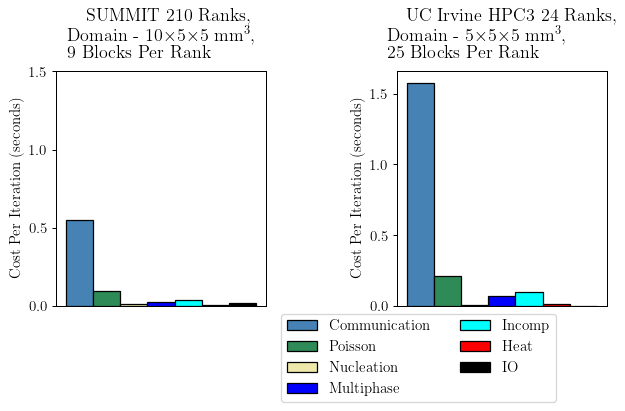

In [8]:
# Plot figure
pyplot.rc("font", family="serif", size=12, weight="bold")
pyplot.rc("axes", labelweight="bold", titleweight="bold")
pyplot.rc("text", usetex=True)
figure = pyplot.figure(figsize=(7,5), dpi=90)

AxList = figure.subplots(1,2)
Titles = [r"SUMMIT 210 Ranks,$\\$Domain - 10$\times$5$\times$5 mm$^3$,$\\$9 Blocks Per Rank", 
          r"UC Irvine HPC3 24 Ranks,$\\$Domain - 5$\times$5$\times$5 mm$^3$,$\\$25 Blocks Per Rank"]

for ax, log, title  in zip(AxList, [SummitNodes05, HPC3], Titles):

    labels = ["Communication", "Poisson", "Nucleation", "Multiphase", "Incomp", "Heat", "IO"]

    bar = []
    color = iter(["steelblue", "seagreen", "palegoldenrod", "blue", "cyan", "red", "black"])
    x = 0.0
    for lb in labels:
        bar.append(ax.bar(x, ((getattr(log,lb.lower())/log.iters)), 
                          color=next(color),
                          edgecolor="black", align='center', width=0.05))
        
        x = x+0.05
               
    ax.set_title(title,pad=40)
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel(r"Cost Per Iteration (seconds)")
    ax.set_yticks([0, 0.5, 1, 1.5])

ax.legend(bar,labels,ncol=2,loc="center",bbox_to_anchor=(0.1, -0.22))
pyplot.tight_layout()

In [9]:
SummitNodes25.evolution/SummitNodes25.iters

1.0693983586937938

In [10]:
SummitNodes12.evolution/SummitNodes12.iters

0.8714736936613395

In [11]:
SummitNodes05.evolution/SummitNodes05.iters

0.7902178057189211